In [2]:
library(MASS)
library(expm)

# The algorithms

In [85]:
set.seed(1)

# Ridge Regression
lm_ridge <- function(X,y,lam){
    p <- ncol(X)
    beta <- solve(t(X)%*%X+lam*diag(p)) %*% t(X)%*%y
    ret <- list(beta=beta)
    return(ret)
}

# Gradient Flow
lm_gf <- function(X,y,t){
    p <- ncol(X)
    n <- nrow(y)
    eigenXX <- eigen(t(X)%*%X/n)
    D <- eigenXX$values
    U <- eigenXX$vectors
    D1 <- 1/D-exp(-t*D)/D
    beta <- 1/n*U%*%(D1*(t(U)%*%(t(X)%*%y)))
    return(list(beta=beta))
}

# SGD
lm_sgd <- function(X,y,beta_old,alpha){
    p <- ncol(X)
    n <- nrow(y)
    m <- 0.2*n
    
    idx <- sample(1:n, m, replace = TRUE)
    X_batch <- X[idx,]
    y_batch <- y[idx,]
    
    # beta <- matrix(0,p,1)
    # for(j in 1:p){
    #     beta[j] <- beta_old[j] - alpha*(1/m)*sum((X_batch%*%beta_old - y_batch)*X_batch[,j])
    # #Updating theta for every variable using batch gradient descent algorithm
    # }
    beta <- beta_old + alpha*(1/m)*t(X_batch)%*%(y_batch - X_batch%*%beta_old)
    return(list(beta=beta))
}

# GD
lm_gd <- function(X,y,beta_old,alpha){
    p <- ncol(X)
    n <- nrow(y)
    # beta <- matrix(0,p,1)
    # for(j in 1:p){
    #     beta[j] <- beta_old[j] - alpha*(1/n)*sum((X%*%beta_old - y)*X[,j])
    # #Updating theta for every variable using batch gradient descent algorithm
    # }
    beta <- beta_old + alpha*(1/n)*t(X)%*%(y - X%*%beta_old)
    return(list(beta=beta))
}

# SGF: Discrete solution of SDE (non-constant covariance)
lm_NC_sde <- function(X,y,beta_old,alpha){
    p <- ncol(X)
    n <- nrow(y)
    m <- 0.2*n
    
    idx <- sample(1:n, m, replace = TRUE)
    X_batch <- X[idx,]
    y_batch <- y[idx,]
    
    # deviation <- (1/m)*t(X_batch)%*%(y_batch - X_batch%*%beta_old)
    # # zk <- matrix(diag(as.vector(rnorm(p,0,1))),ncol=p)
    # zk <- matrix(rnorm(n=p, mean=0, sd=1),nrow=p,ncol=1)
    # # zk <- matrix(soundgen:::rnorm_truncated(n=p, mean=0, sd=1, low=0, high=NULL),nrow=p,ncol=1)
    # beta <- beta_old + alpha*(1/n)*t(X)%*%(y - X%*%beta_old) + alpha*as.numeric(cov(deviation)**0.5) * zk
    
    cov_batch <- Cov_batch(X_batch,y_batch,m,p,beta_old)
    eigenQ <- eigen(1/m * cov_batch)
    D <- eigenQ$values
    U <- eigenQ$vectors
    zk <- matrix(rnorm(n=p, mean=0, sd=1),nrow=p,ncol=1)
    beta <- beta_old + alpha*(1/n)*t(X)%*%(y - X%*%beta_old) + alpha* t(U%*%diag(D**0.5)%*%t(U)) %*% zk
    return(list(beta=beta))
}

Cov_batch <- function(X_batch,y_batch,m,p,beta_old){
    item_1 <- matrix(0,nrow=p,ncol=p)
    sum_1 <- matrix(0,nrow=p,ncol=p)
    for(i in 1:m){
        sum_1 <- sum_1 + ( as.matrix(X_batch[i,])%*%(y_batch[i]-t(X_batch[i,])%*%beta_old) ) %*% t( as.matrix(X_batch[i,])%*%(y_batch[i]-t(X_batch[i,])%*%beta_old) )
    }
    item_1 <- 1/m*sum_1
    
    item_2 <- matrix(0,nrow=p,ncol=p)
    sum_2 <- matrix(0,nrow=p,ncol=1)
    for(i in 1:m){
        sum_2 <- sum_2 + as.matrix(X_batch[i,])%*%(y_batch[i]-t(X_batch[i,])%*%beta_old)
    }
    item_2 <- (1/m*sum_2)%*%t(1/m*sum_2)
    return (item_1 - item_2)
}

# SGF: Discrete solution of SDE (constant covariance)
lm_C_sde <- function(X,y,beta_old,alpha){
    # deviation <- (1/n)*t(X)%*%(y - X%*%beta_old)
    # # zk <- matrix(diag(as.vector(rnorm(p,0,1))),ncol=p)
    # zk <- matrix(rnorm(n=p, mean=0, sd=1),nrow=p,ncol=1)
    # # zk <- matrix(soundgen:::rnorm_truncated(n=p, mean=0, sd=1, low=0, high=NULL),nrow=p,ncol=1)
    # beta <- beta_old + alpha*(1/n)*t(X)%*%(y - X%*%beta_old) + alpha*as.numeric(cov(deviation)**0.5) * zk
    p <- ncol(X)
    n <- nrow(y)
    m <- 0.2*n
    
    eigenXX <- eigen(1/m*1/n*t(X)%*%X)
    D <- eigenXX$values
    U <- eigenXX$vectors
    zk <- matrix(rnorm(n=p, mean=0, sd=1),nrow=p,ncol=1)
    beta <- beta_old + alpha*(1/n)*t(X)%*%(y - X%*%beta_old) + alpha * t(U%*%diag(D**0.5)%*%t(U)) %*% zk
    
    return(list(beta=beta))
}

# SGF: Continuous solution of SDE
lm_Conti_sde <- function(X,y,t,beta_old,alpha){
    p <- ncol(X)
    n <- nrow(y)
    m <- 0.2*n
    
    idx <- sample(1:n, m, replace = TRUE)
    X_batch <- X[idx,]
    y_batch <- y[idx,]
    
    eigenXX <- eigen(t(X)%*%X/n)
    D <- eigenXX$values
    U <- eigenXX$vectors
    D1 <- 1/D-exp(-t*D)/D
    beta_gf <- 1/n*U%*%(D1*(t(U)%*%(t(X)%*%y)))
    
    cov_batch <- Cov_batch(X_batch,y_batch,m,p,beta_old)
    eigenQ <- eigen(1/m * cov_batch)
    D <- eigenQ$values
    U <- eigenQ$vectors
    limit_approximate <- limit_appro(D,alpha,t)
    beta <- beta_gf +  U%*%diag(D**0.5)%*%t(U) %*% limit_approximate
    return(list(beta=beta))
}

limit_appro <- function(D,alpha,t){
    appro <- matrix(0,p,1)
    for(i in 1:p){
        sum <- 0
        e_value <- c(D)[i]
        for (k in 1:round(t/alpha)){
            sum <- sum + exp((k*alpha-t)*e_value)*rnorm(n=1, mean=0, sd=alpha)
        }
        appro[i] <- sum
    }
    return(appro)
}

# Simulation I

In [87]:
n <- 100
ntest <- 300
p <- 10
nrep <- 1
nlam <- 50 # number of lambdas for ridge
nt <- 100 # number of lambdas for GF
nk<- 1000 # number of lambdas for batch-GD and SGD

sb <- 0.5
s2 <- 1-sb
beta <- rnorm(p,0,sqrt(sb))
X <- matrix(rnorm(n*p),n,p)/sqrt(p)
y0 <- X%*%beta

D <- eigen(t(X)%*%X)$values
loglam <- seq(2*log10(max(D)),-1*log10(10),length.out = nlam)
lam_seq <- 10^(loglam)
logt <- seq(-2*log10(max(D)),1*log10(10),length.out = nt)
t_seq <- 10^(logt)#seq(0,10,length.out = nt)

Xtest <- matrix(rnorm(ntest*p),ntest,p)/sqrt(p)
ytest0 <- Xtest%*%beta

beta_ridge <- array(0,dim=c(nrep,p,nlam))
beta_gf <- array(0,dim=c(nrep,p,nt))
beta_sgd <- array(0,dim=c(nrep,p,nk))
beta_gd <- array(0,dim=c(nrep,p,nk))
beta_NC_sde <- array(0,dim=c(nrep,p,nk))
beta_C_sde <- array(0,dim=c(nrep,p,nk))
beta_Conti_sde <- array(0,dim=c(nrep,p,nt))

yhat_ridge <- array(0,dim = c(nrep,ntest,nlam))
yhat_gf <- array(0,dim = c(nrep,ntest,nt))
err_ridge <- matrix(0,nrep,nlam)
err_gf <- matrix(0,nrep,nt)

for(i in 1:nrep){
    e <- rnorm(n,0,sqrt(s2))
    y <- y0+e
    data_mat <- data.frame(y=y,X=X)
    ytest <- ytest0 + rnorm(ntest,0,sqrt(s2))
    # fit ridge
    for(j in 1:nlam){
        fit_ridge <- lm_ridge(X,y,lam_seq[j])
        beta_ridge[i,,j] <- fit_ridge$beta
    }

    # fit gradient flow
    for(j in 1:nt){
        fit_gf <- lm_gf(X,y,t_seq[j])
        beta_gf[i,,j] <- fit_gf$beta
    }

    # fit Stochastic gradient descent
    alpha = 0.01
    beta_sgd[i,,1] <- matrix(0,p,1)
    for(j in 2:nk){
        fit_sgd <- lm_sgd(X,y,beta_sgd[i,,j-1],alpha)
        beta_sgd[i,,j] <- fit_sgd$beta

    }
    # fit gradient descent
    alpha = 0.01
    beta_gd[i,,1] <- matrix(0,p,1)
    for(j in 2:nk){
        fit_gd <- lm_gd(X,y,beta_gd[i,,j-1],alpha)
        beta_gd[i,,j] <- fit_gd$beta
    }
    
    # fit NC_sde
    alpha = 0.01
    beta_NC_sde[i,,1] <- matrix(0,p,1)
    for(j in 2:nk){
        fit_NC_sde <- lm_NC_sde(X,y,beta_NC_sde[i,,j-1],alpha)
        beta_NC_sde[i,,j] <- fit_NC_sde$beta
    }  
    # fit C_sde
    alpha = 0.01
    beta_C_sde[i,,1] <- matrix(0,p,1)
    for(j in 2:nk){
        fit_C_sde <- lm_C_sde(X,y,beta_C_sde[i,,j-1],alpha)
        beta_C_sde[i,,j] <- fit_C_sde$beta
    }   
    
    # fit Conti_sde
    alpha = 0.001
    beta_Conti_sde[i,,1] <- matrix(0,p,1)
    for(j in 2:nt){
        fit_Conti_sde <- lm_Conti_sde(X,y,t_seq[j],beta_Conti_sde[i,,j-1],alpha)
        beta_Conti_sde[i,,j] <- fit_Conti_sde$beta
    }    
}


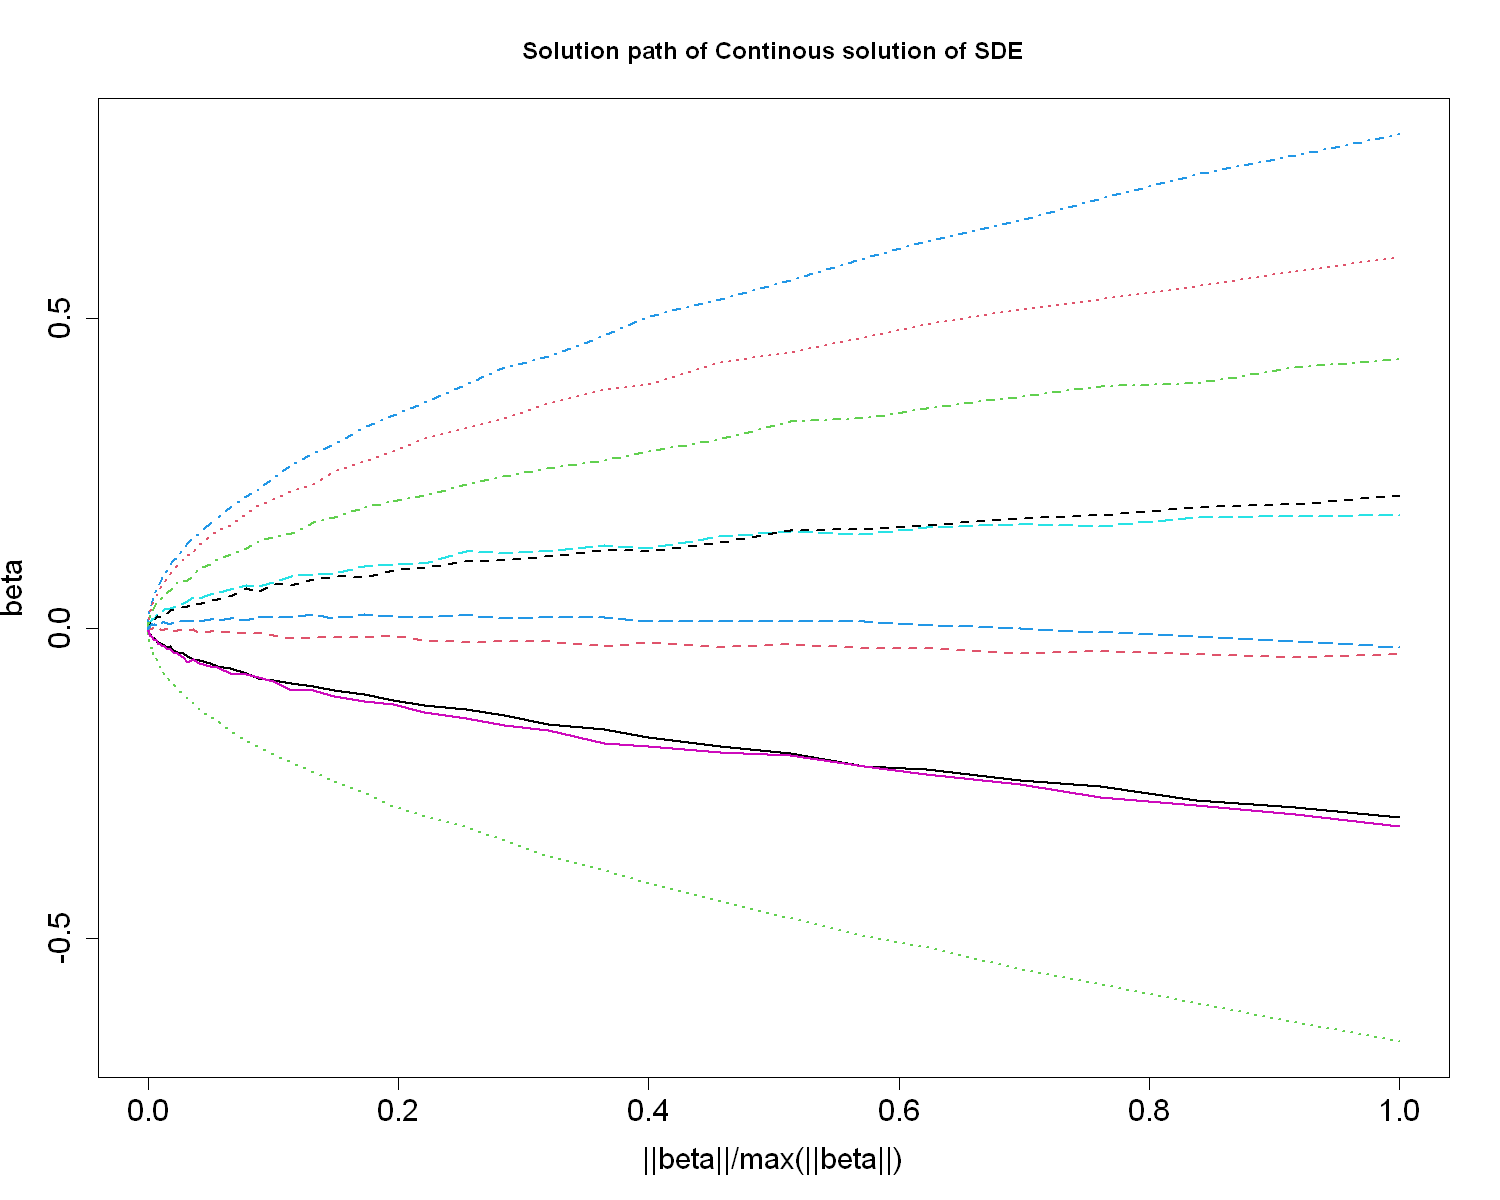

In [80]:
options(repr.plot.width=12.5, repr.plot.height=10)
matplot(y=t(beta_Conti_sde[1,,]),
        x=colSums(beta_Conti_sde[1,,]^2)/max(colSums(beta_Conti_sde[1,,]^2)),
        type = "l",ylab="beta",xlab="||beta||/max(||beta||)",lwd=2,cex.axis=1.5,cex.lab=1.5,
        main="Solution path of Continous solution of SDE")

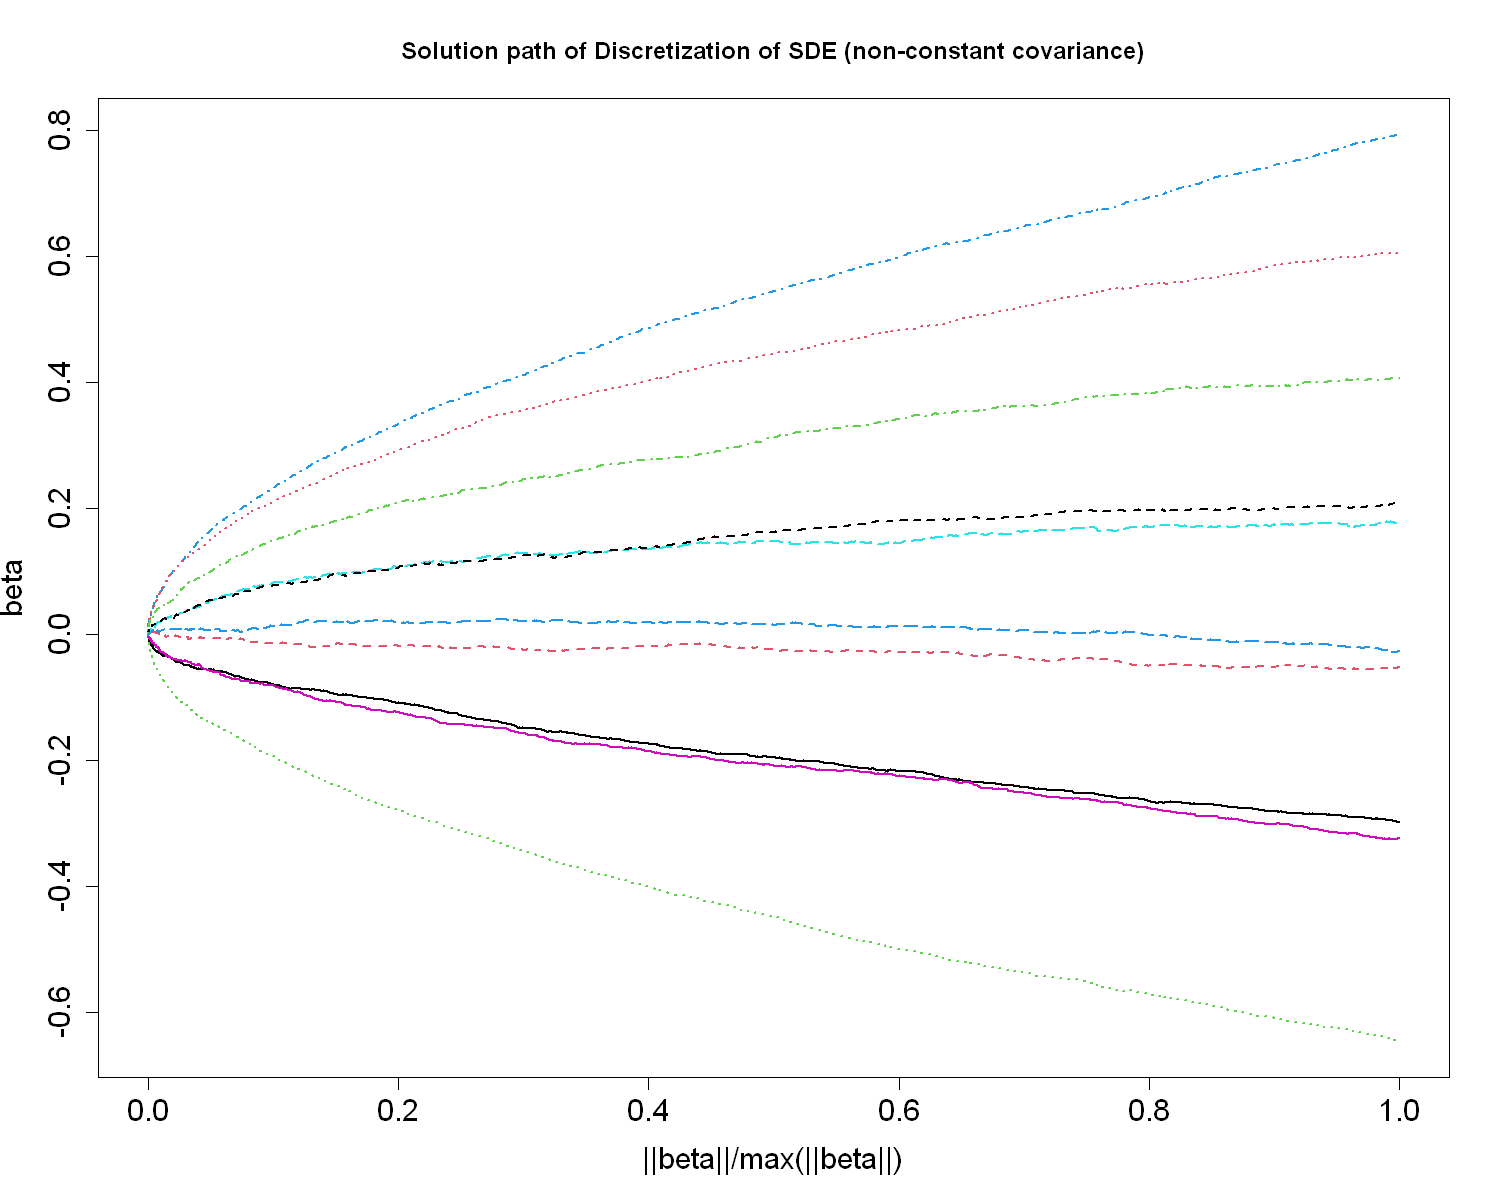

In [81]:
options(repr.plot.width=12.5, repr.plot.height=10)
matplot(y=t(beta_NC_sde[1,,]),
        x=colSums(beta_NC_sde[1,,]^2)/max(colSums(beta_NC_sde[1,,]^2)),
        type = "l",ylab="beta",xlab="||beta||/max(||beta||)",lwd=2,cex.axis=1.5,cex.lab=1.5,
        main="Solution path of Discretization of SDE (non-constant covariance)")

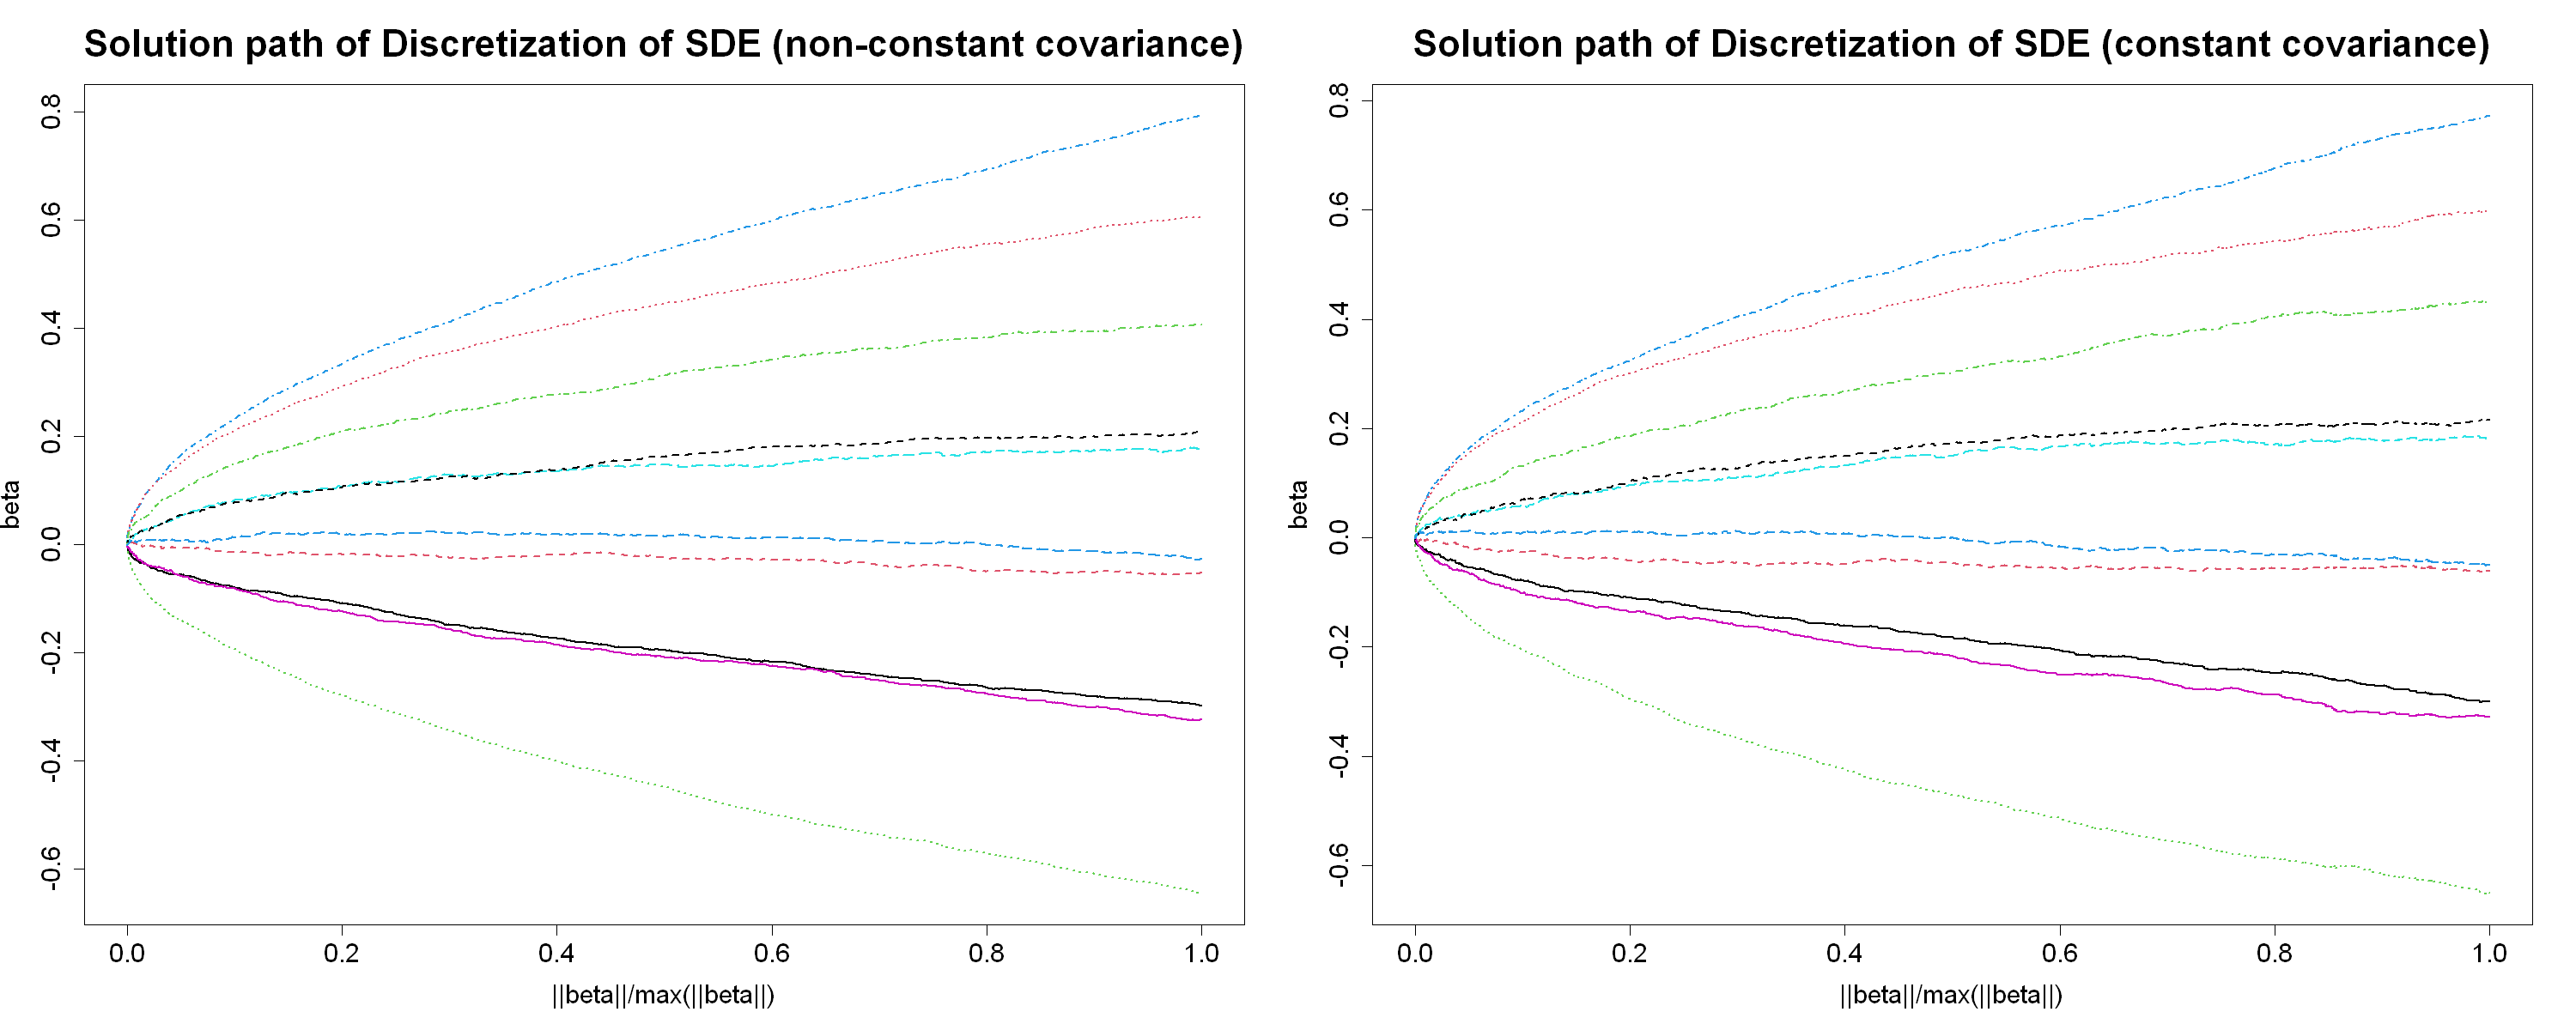

In [82]:
options(repr.plot.width=25, repr.plot.height=10)
par(mfrow=c(1,2))
matplot(y=t(beta_NC_sde[1,,]),
        x=colSums(beta_NC_sde[1,,]^2)/max(colSums(beta_NC_sde[1,,]^2)),cex.main=2.2,
        type = "l",ylab="beta",xlab="||beta||/max(||beta||)",lwd=2,cex.axis=1.5,cex.lab=1.5,
        main="Solution path of Discretization of SDE (non-constant covariance)")
matplot(y=t(beta_C_sde[1,,]),
        x=colSums(beta_C_sde[1,,]^2)/max(colSums(beta_C_sde[1,,]^2)),cex.main=2.2,
        type = "l",ylab="beta",xlab="||beta||/max(||beta||)",lwd=2,cex.axis=1.5,cex.lab=1.5,
        main="Solution path of Discretization of SDE (constant covariance)")

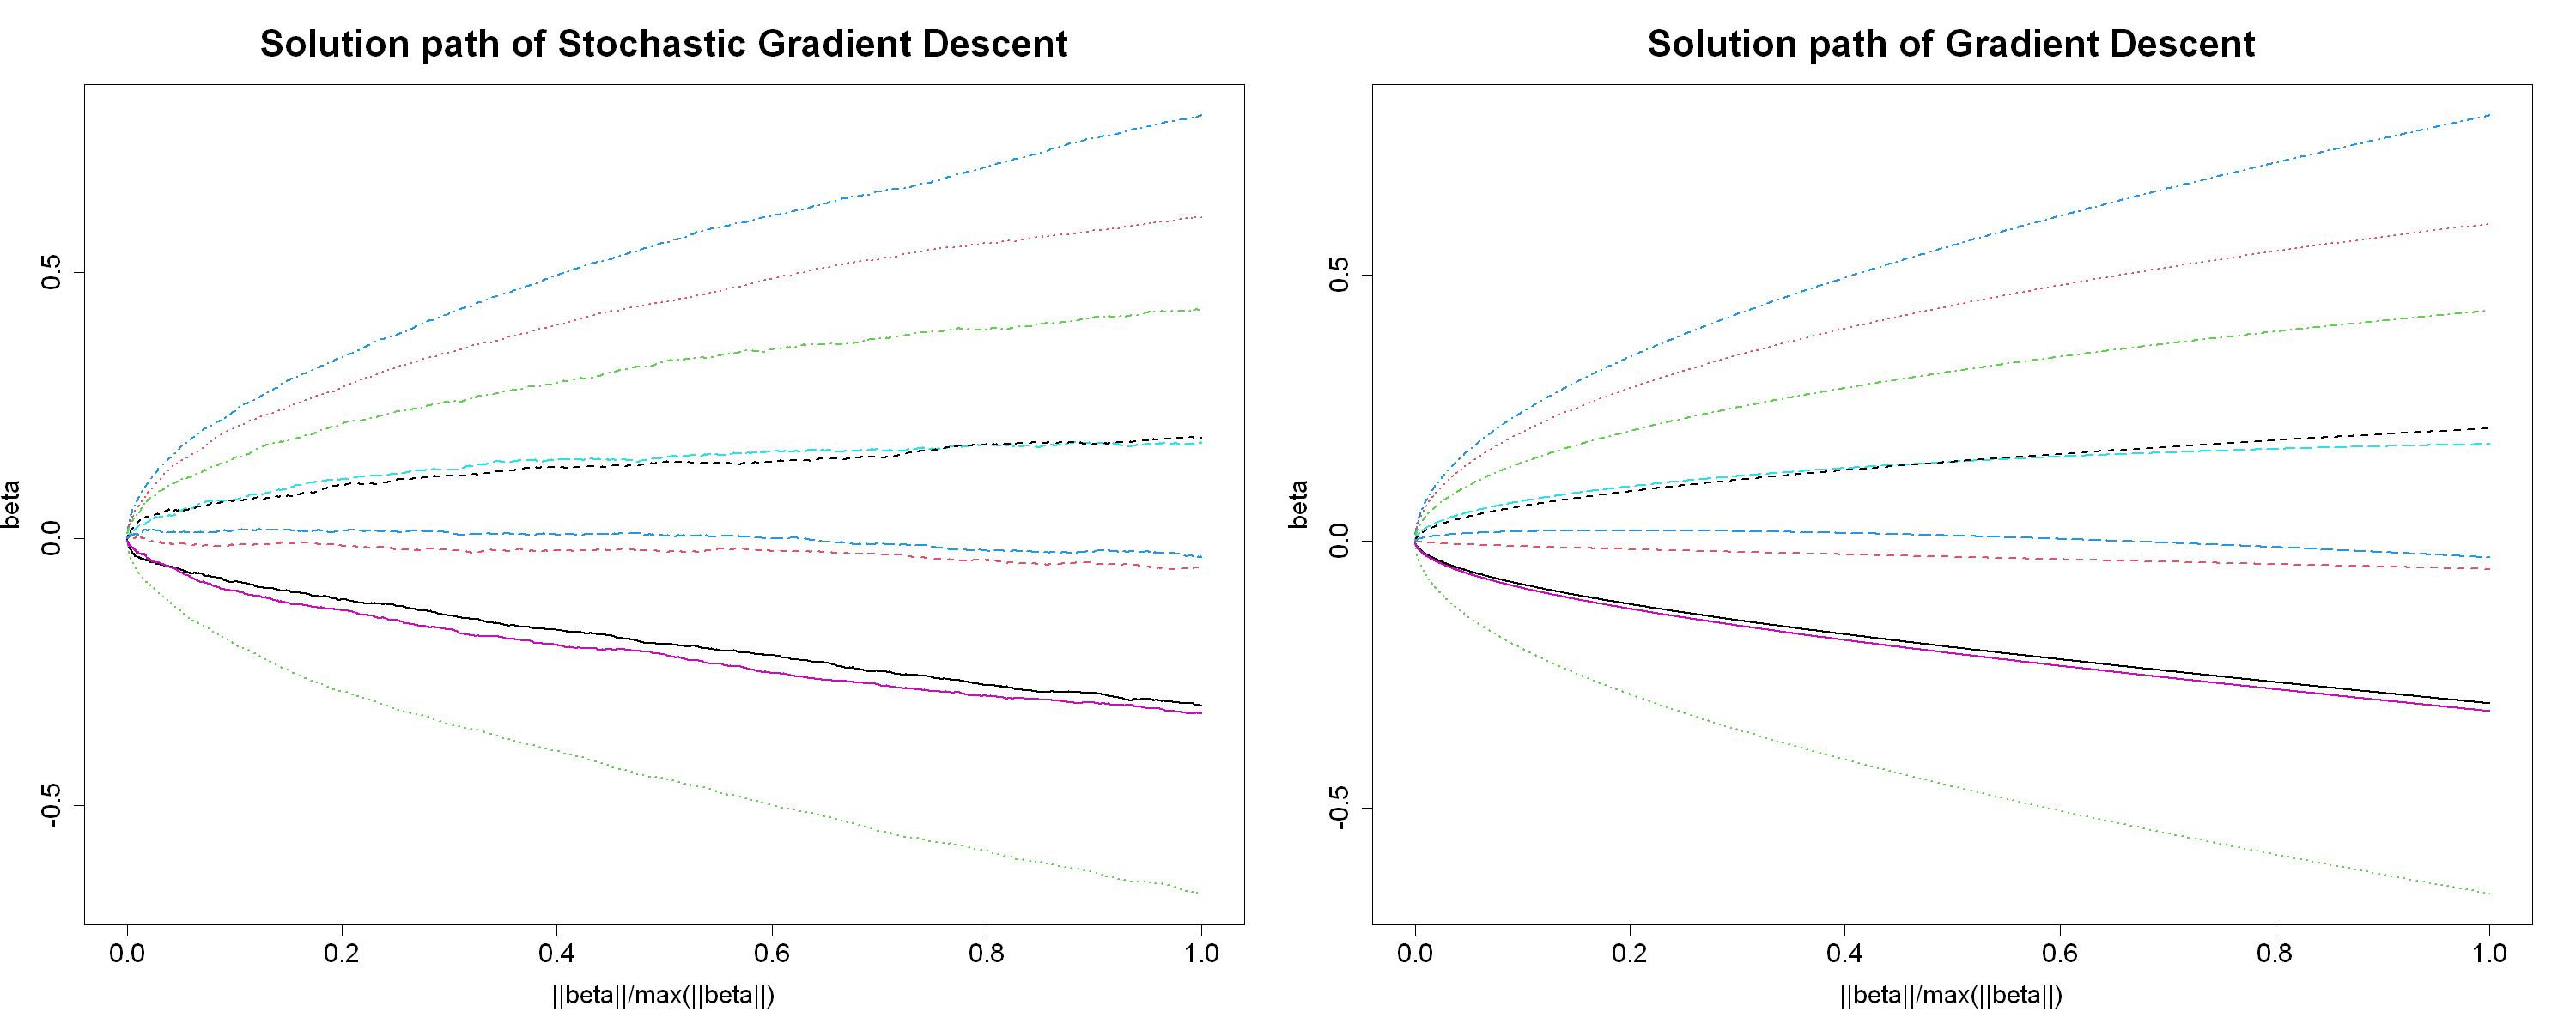

In [83]:
options(repr.plot.width=25, repr.plot.height=10)
par(mfrow=c(1,2))
matplot(y=t(beta_sgd[1,,]),
        x=colSums(beta_sgd[1,,]^2)/max(colSums(beta_sgd[1,,]^2)),cex.main=2.2,
        type = "l",ylab="beta",xlab="||beta||/max(||beta||)",lwd=2,cex.axis=1.5,cex.lab=1.5,
        main="Solution path of Stochastic Gradient Descent")
matplot(y=t(beta_gd[1,,]),
        x=colSums(beta_gd[1,,]^2)/max(colSums(beta_gd[1,,]^2)),cex.main=2.2,
        type = "l",ylab="beta",xlab="||beta||/max(||beta||)",lwd=2,cex.axis=1.5,cex.lab=1.5,
        main="Solution path of Gradient Descent")

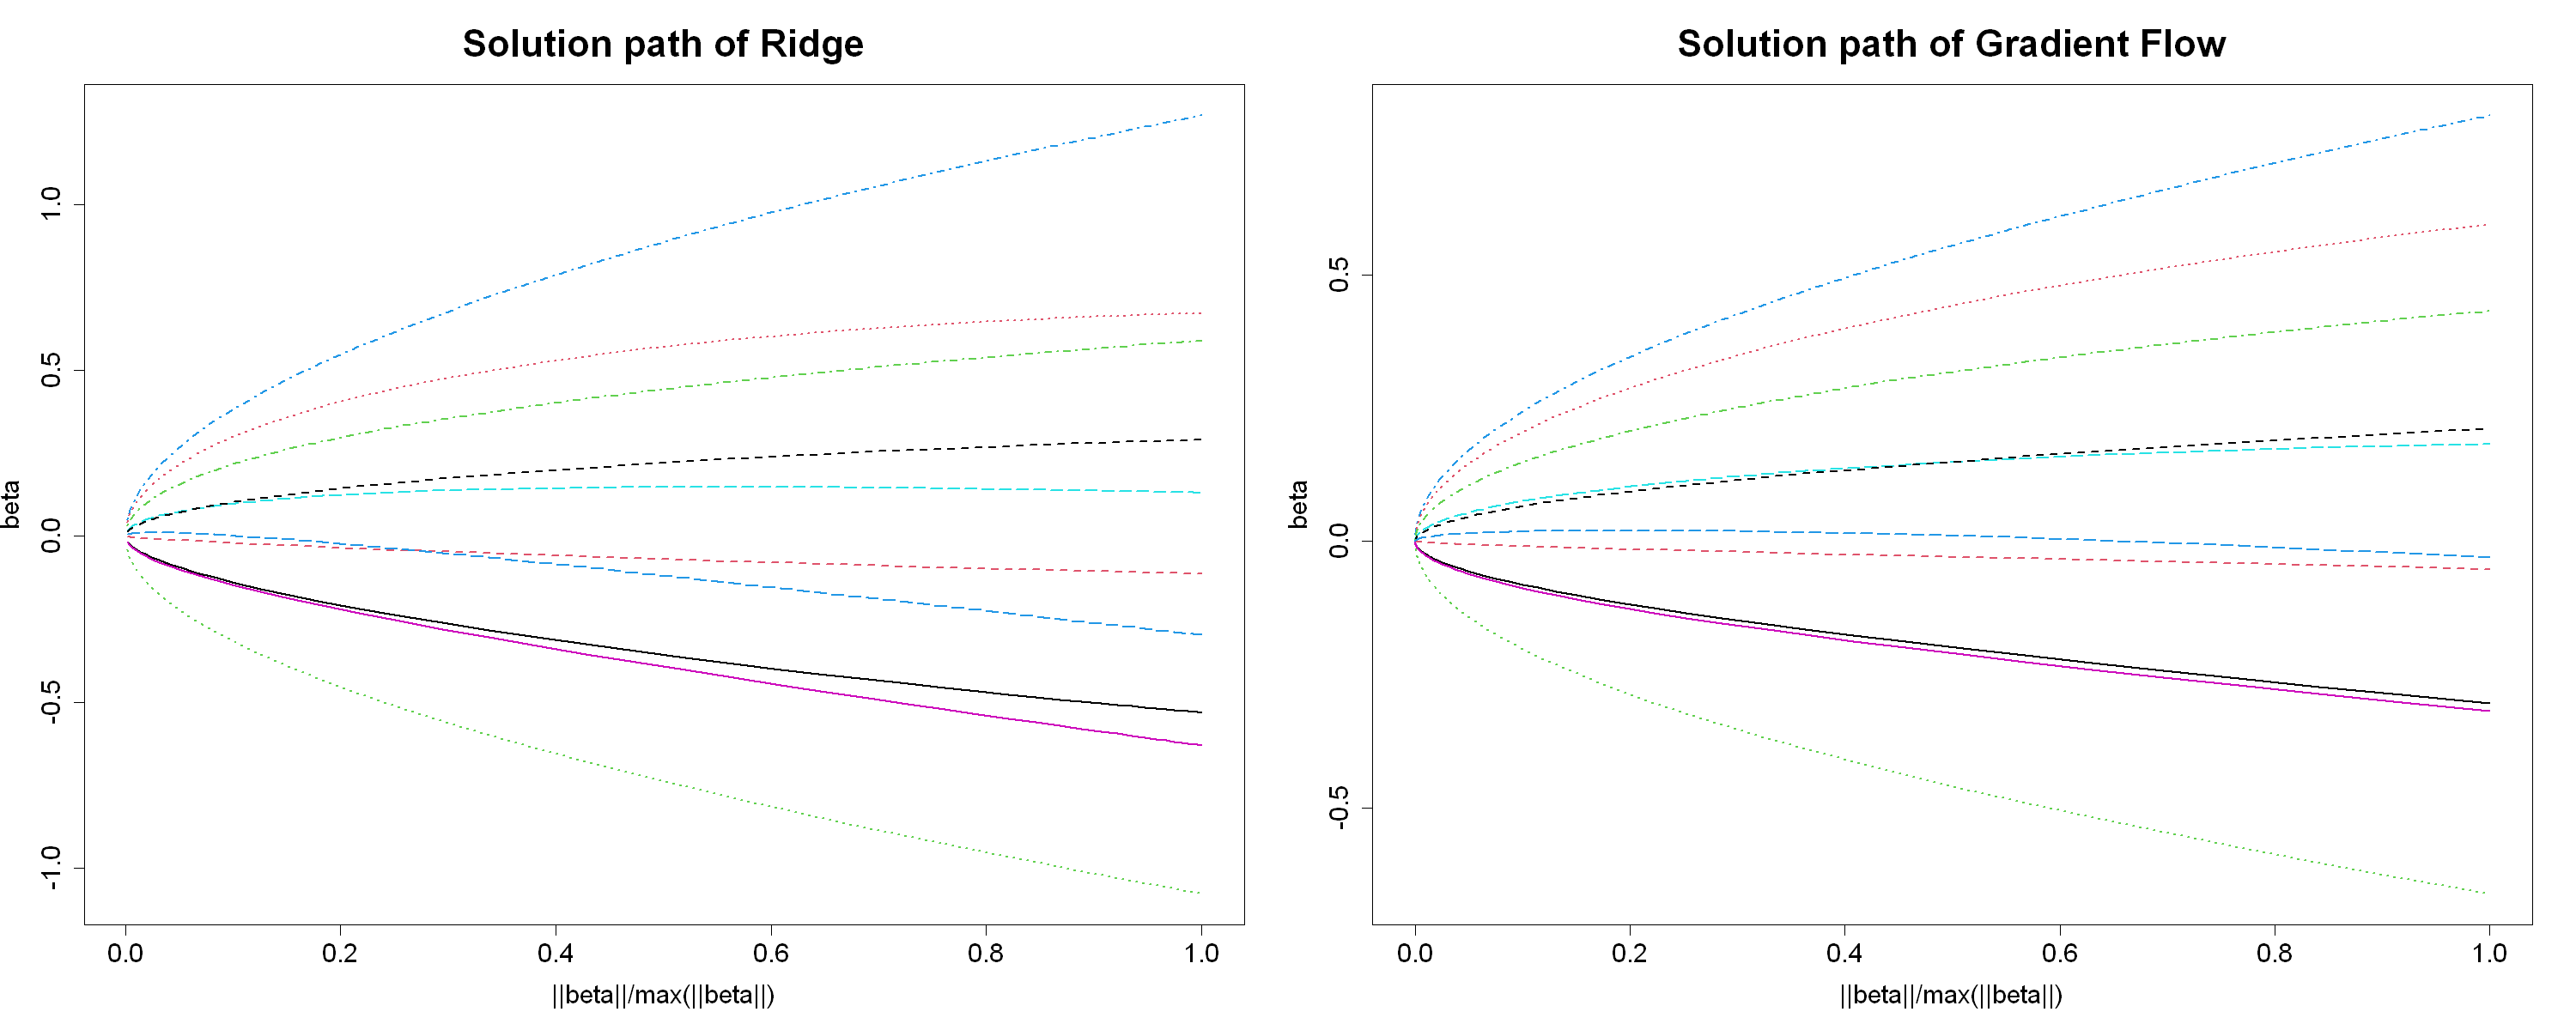

In [84]:
options(repr.plot.width=25, repr.plot.height=10)
par(mfrow=c(1,2))
matplot(y=t(beta_ridge[1,,]),
        x=colSums(beta_ridge[1,,]^2)/max(colSums(beta_ridge[1,,]^2)),cex.main=2.2,
        type = "l",ylab="beta",xlab="||beta||/max(||beta||)",lwd=2,cex.axis=1.5,cex.lab=1.5,
        main="Solution path of Ridge")
matplot(y=t(beta_gf[1,,]),
        x=colSums(beta_gf[1,,]^2)/max(colSums(beta_gf[1,,]^2)),cex.main=2.2,
        type = "l",ylab="beta",xlab="||beta||/max(||beta||)",lwd=2,cex.axis=1.5,cex.lab=1.5,
        main="Solution path of Gradient Flow")

# Simulation II

In [89]:
n <- 200
# ntest <- 300
p <- 2
nrep <- 1
nlam <- 50 # number of lambdas for ridge
nt <- 200 # number of lambdas for GF
nk<- 2000 # number of lambdas for batch-GD and SGD

sb <- 0.3
s2 <- 0.1
beta <- rnorm(p,0,sqrt(sb))
X <- matrix(rnorm(n*p),n,p)/sqrt(p)
y0 <- X%*%beta

D <- eigen(t(X)%*%X)$values
loglam <- seq(2*log10(max(D)),-log10(10),length.out = nlam)
lam_seq <- 10^(loglam)
logt <- seq(-2*log10(max(D)),log10(10),length.out = nt)
t_seq <- 10^(logt)#seq(0,10,length.out = nt)

beta_ridge <- array(0,dim=c(nrep,p,nlam))
beta_NC_sde <- array(0,dim=c(nrep,p,nk))
beta_C_sde <- array(0,dim=c(nrep,p,nk))
beta_Conti_sde <- array(0,dim=c(nrep,p,nt))

for(i in 1:nrep){
    e <- rnorm(n,0,sqrt(s2))
    y <- y0+e

    # fit ridge
    for(j in 1:nlam){
        fit_ridge <- lm_ridge(X,y,lam_seq[j])
        beta_ridge[i,,j] <- fit_ridge$beta
    }
    
    
    # fit NC_sde
    alpha = 0.005
    beta_NC_sde[i,,1] <- matrix(0,p,1)
    for(j in 2:nk){
        fit_NC_sde <- lm_NC_sde(X,y,beta_NC_sde[i,,j-1],alpha)
        beta_NC_sde[i,,j] <- fit_NC_sde$beta
    }  
    
    # fit C_sde
    alpha = 0.005
    beta_C_sde[i,,1] <- matrix(0,p,1)
    for(j in 2:nk){
        fit_C_sde <- lm_C_sde(X,y,beta_C_sde[i,,j-1],alpha)
        beta_C_sde[i,,j] <- fit_C_sde$beta
    }  
    
    # fit Conti_sde
    alpha = 0.005
    beta_Conti_sde[i,,1] <- matrix(0,p,1)
    for(j in 2:nt){
        fit_Conti_sde <- lm_Conti_sde(X,y,t_seq[j],beta_Conti_sde[i,,j-1],alpha)
        beta_Conti_sde[i,,j] <- fit_Conti_sde$beta
    } 
}


In [62]:
beta

[1] 0.5808429 0.6329099

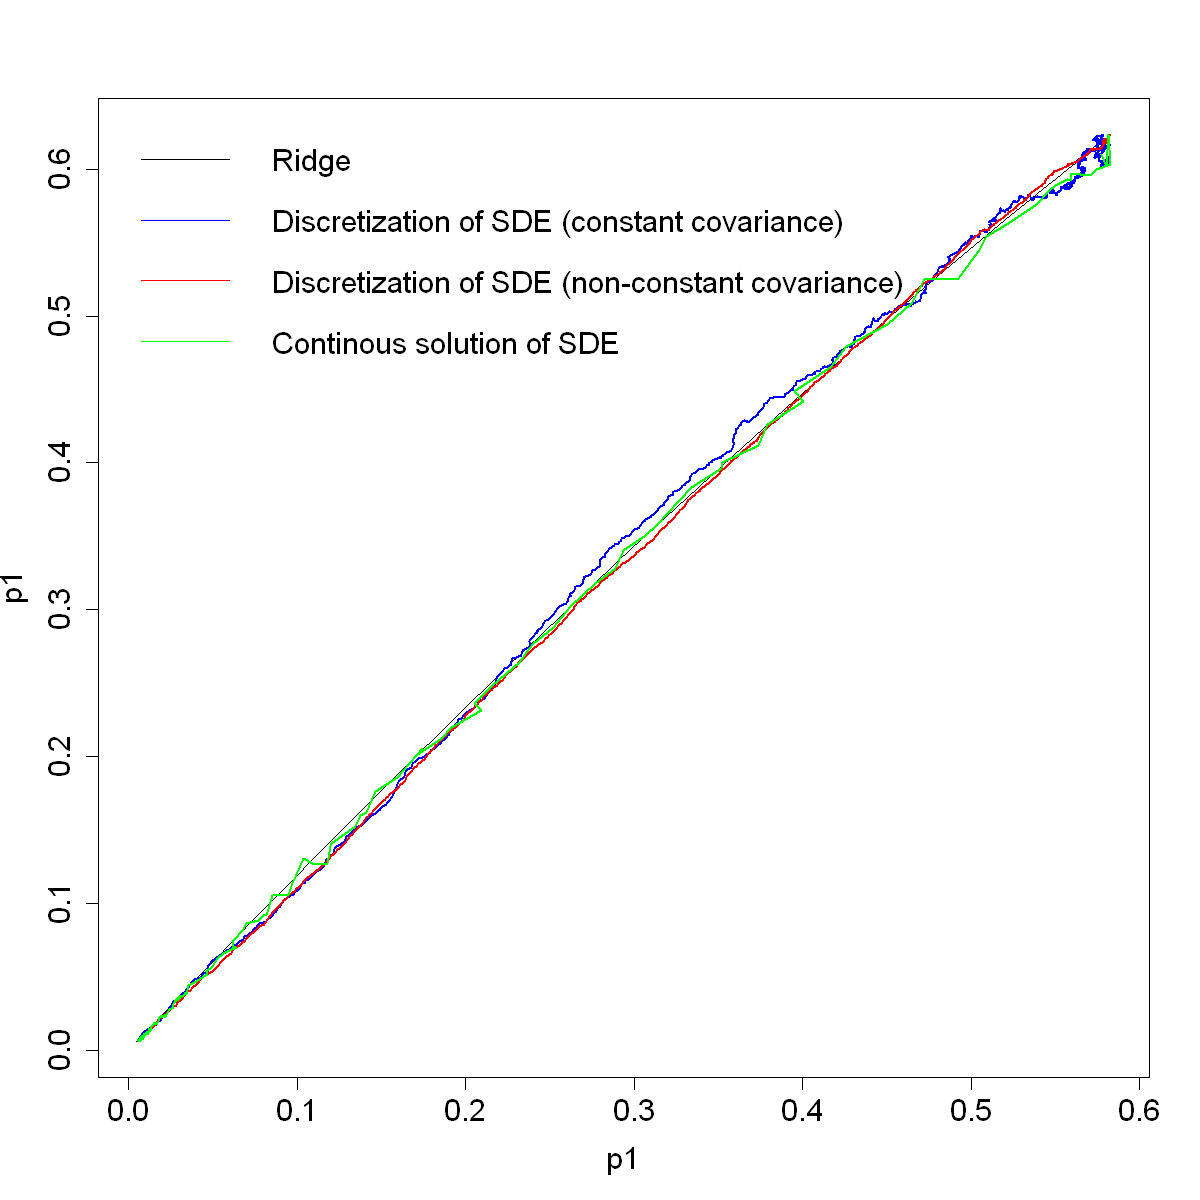

In [64]:
options(repr.plot.width=10, repr.plot.height=10)
NC_sde <- beta_NC_sde[1,,]
C_sde <- beta_C_sde[1,,]
Conti_sde <- beta_Conti_sde[1,,]
ridge <- beta_ridge[1,,]
plot(x=ridge[1,],y=ridge[2,],type = "l",col="black",ylab="p1",xlab="p1",cex.axis=1.5,cex.lab=1.5)
par(new=TRUE)
plot(x=C_sde[1,],y=C_sde[2,],type = "l",lwd = 2,col="blue",ylab="p1",xlab="p1",ann = F, bty = "n", xaxt = "n", yaxt ="n")
par(new=TRUE)
plot(x=NC_sde[1,],y=NC_sde[2,],type = "l",lwd = 2,col="red",ylab="p1",xlab="p1",ann = F, bty = "n", xaxt = "n", yaxt ="n")
par(new=TRUE)
plot(x=Conti_sde[1,],y=Conti_sde[2,],type = "l",lwd = 2,col="green",ylab="p1",xlab="p1",ann = F, bty = "n", xaxt = "n", yaxt ="n")
legend(x = 'topleft', 
       legend = c('Ridge', 'Discretization of SDE (constant covariance)', 'Discretization of SDE (non-constant covariance)', 'Continous solution of SDE'),
       lty = 1,cex=1.5,
       col = c('black', 'blue', 'red', 'green'),
       bty = 'n')

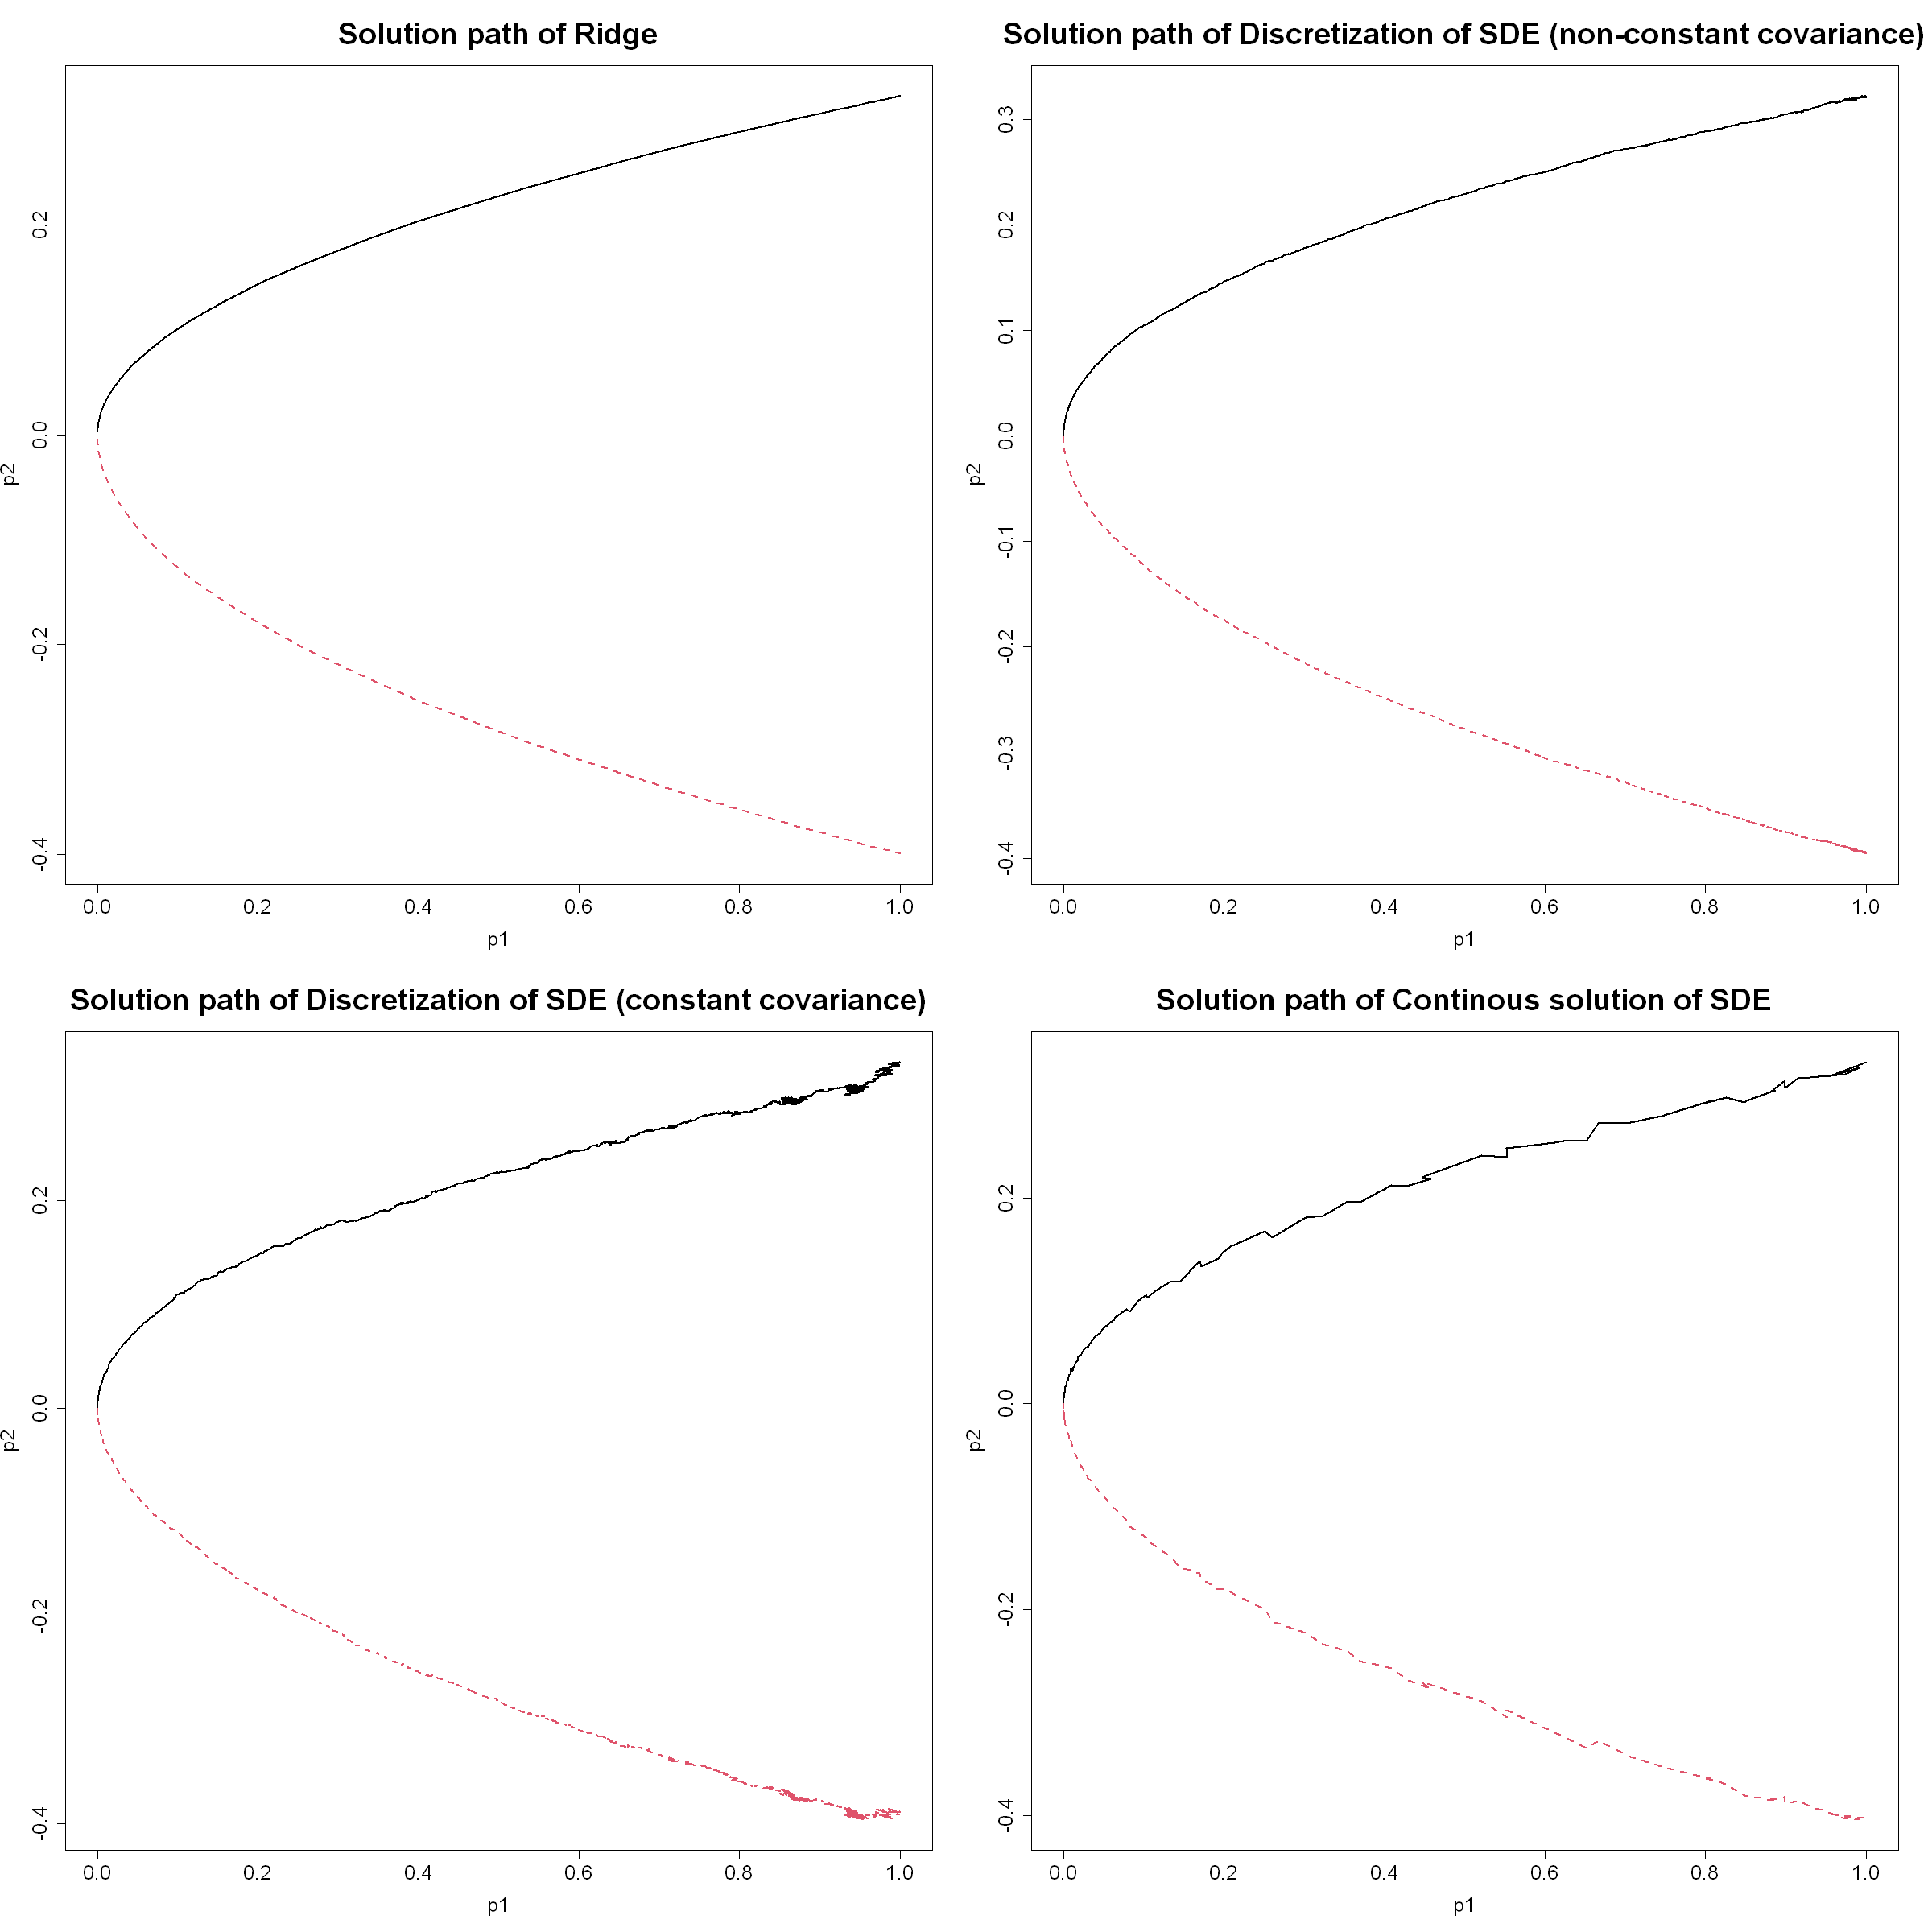

In [21]:
options(repr.plot.width=20, repr.plot.height=20)
par(mfrow=c(2,2))
matplot(y=t(beta_ridge[1,,]),
        x=colSums(beta_ridge[1,,]^2)/max(colSums(beta_ridge[1,,]^2)),
        type = "l",ylab="p2",xlab="p1",lwd=2,cex.axis=1.5,cex.lab=1.5,cex.main=2.2,
        main="Solution path of Ridge")
matplot(y=t(beta_NC_sde[1,,]),
        x=colSums(beta_NC_sde[1,,]^2)/max(colSums(beta_NC_sde[1,,]^2)),
        type = "l",ylab="p2",xlab="p1",lwd=2,cex.axis=1.5,cex.lab=1.5,cex.main=2.2,
        main="Solution path of Discretization of SDE (non-constant covariance)")
matplot(y=t(beta_C_sde[1,,]),
        x=colSums(beta_C_sde[1,,]^2)/max(colSums(beta_C_sde[1,,]^2)),
        type = "l",ylab="p2",xlab="p1",lwd=2,cex.axis=1.5,cex.lab=1.5,cex.main=2.2,
        main="Solution path of Discretization of SDE (constant covariance)")
matplot(y=t(beta_Conti_sde[1,,]),
        x=colSums(beta_Conti_sde[1,,]^2)/max(colSums(beta_Conti_sde[1,,]^2)),
        type = "l",ylab="p2",xlab="p1",lwd=2,cex.axis=1.5,cex.lab=1.5,cex.main=2.2,
        main="Solution path of Continous solution of SDE")

# Simulation III

## Risk Bounds rho=0

In [71]:
n <- 25
p <- 50
m <- 0.2*n
nrep <- 1
nlam <- 200 # number of lambdas for ridge
nt <- 200 # number of lambdas for GF
nk<- 10240 # number of lambdas for batch-GD and SGD

sigma_noise <- 1
r <- 1
rou <- 0

Sigma <- matrix(rou,p,p)
diag(Sigma) <- 1
eigenS <- eigen(Sigma)
D <- eigenS$values
U <- eigenS$vectors
sigma <- U%*%diag(D**0.5)%*%t(U)
W <- matrix(rnorm(n*p,mean=0,sd=sigma_noise),n,p)
X <- W%*%sigma

# D <- eigen(t(X)%*%X)$values
loglam <- seq(log(2^10, 2),-log(2^10, 2),length.out = nlam)
lam_seq <- 2^(loglam)
logt <- seq(-log(2^10, 2),log(2^10, 2),length.out = nt)
t_seq <- 2^(logt)

In [67]:
risk_ridge <- array(0,dim=c(nlam,1))
risk_gf <- array(0,dim=c(nt,1))
risk_NC_sde <- array(0,dim=c(nk,1))

Alpha <- (r^2*n)/(sigma_noise^2*p)

for (i in 1:nlam){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    lambda <- lam_seq[i]
    sum <- 0
    for (j in 1:p){
        sum <- sum + (Alpha*lambda^2+D[j]) / (D[j]+lambda)^2
    } 
    risk_ridge[i] <- sigma_noise^2/n*sum
}

for (i in 1:nt){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    t <- t_seq[i]
    sum <- 0
    for (j in 1:p){
        sum <- sum + Alpha*exp(-2*t*D[j]) + (1-exp(-t*D[j]))^2 / D[j]
    } 
    risk_gf[i] <- sigma_noise^2/n*sum
}

for (i in 1:nk){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    Epsilon = 0.1
    t <- i*Epsilon
    sum <- 0
    for (j in 1:p){
        u = 2*min(D) - n*(n*Epsilon/m)^2*(max(D))^2
        sum <- sum + D[j]/(D[j]-u/2)*(exp(-u*t)-exp(-2*t*D[j]))
    } 
    term_1 <- 0
    term_2 <- 1.6862*sum(diag(sigma_noise^2 * solve(t(X)%*%X+1/t*diag(p))%*%t(X)%*%X%*%solve(t(X)%*%X+1/t*diag(p))))
    # term_3 <- Epsilon*n/m*sum
    term_3 <- 0
    risk_NC_sde[i] <- term_1 + term_2 + term_3
}

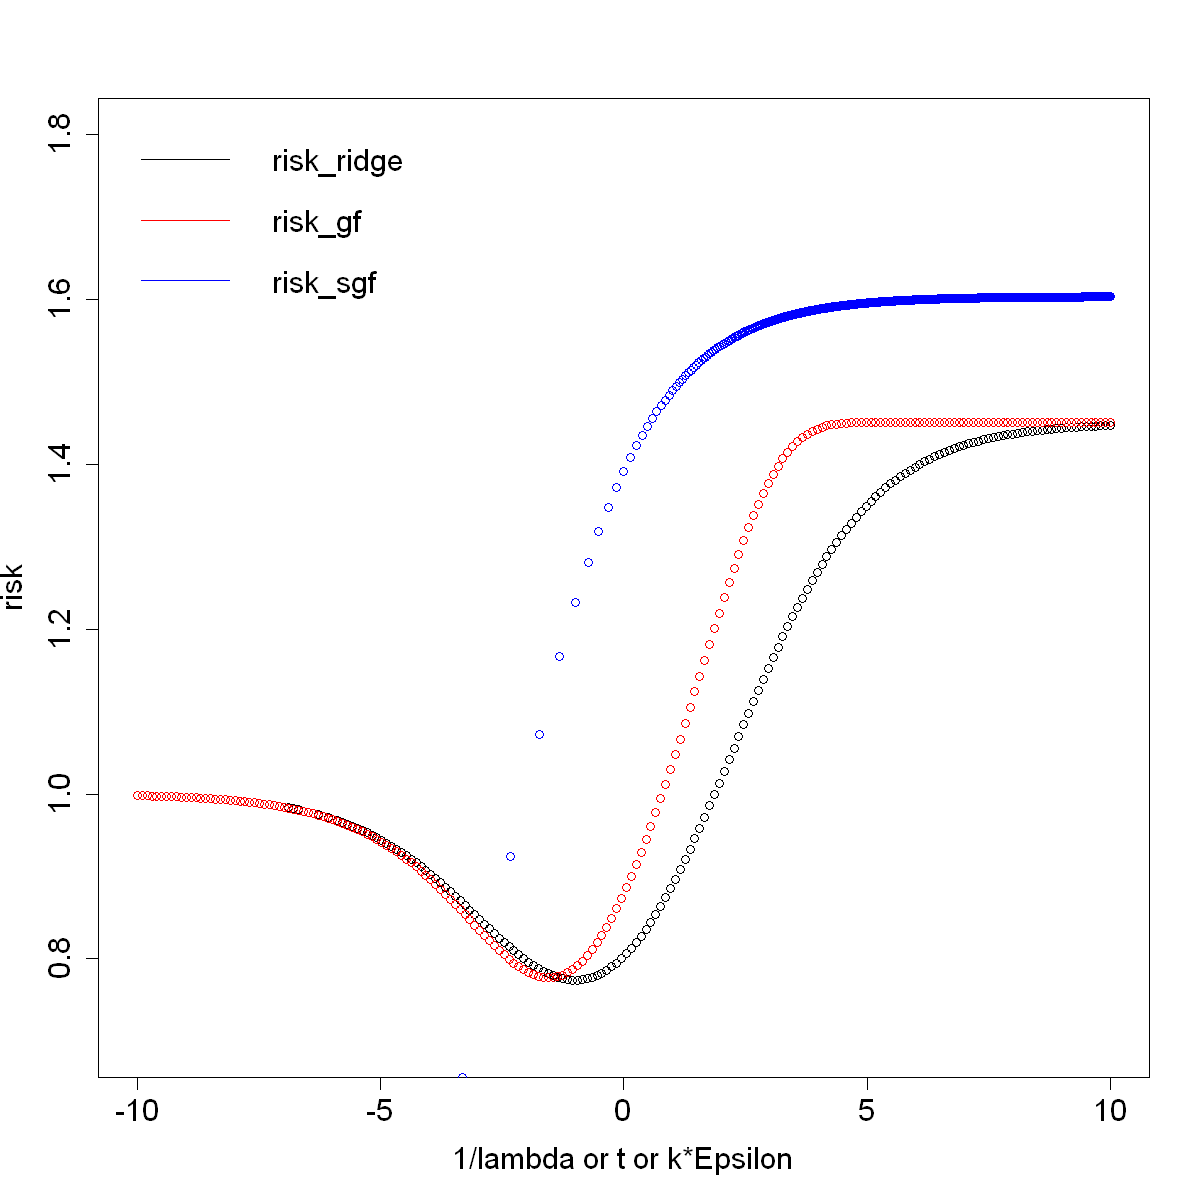

In [69]:
options(repr.plot.width=10, repr.plot.height=10)
plot(1, 1, xlim = c(-10, 10),ylim = c(0.7, 1.8), type = 'n',xlab="1/lambda or t or k*Epsilon",ylab = "risk",cex.axis=1.5,cex.lab=1.5,)   
points(log(1/lam_seq,2), risk_ridge, lty = 1,lwd=1, col = 'black')
points(log(t_seq,2), risk_gf, lty = 1,,lwd=1, col = 'red')  
points(log(seq(1:nk)*Epsilon,2), risk_NC_sde, lty = 1,,lwd=1, col = 'blue') 
legend(x = 'topleft', 
       legend = c('risk_ridge', 'risk_gf', 'risk_sgf'),
       lty = 1,cex=1.5,
       col = c('black', 'red', 'blue'),
       bty = 'n')

## Risk Bounds rho=0.5

In [72]:
n <- 25
p <- 50
m <- 0.2*n
nrep <- 1
nlam <- 200 # number of lambdas for ridge
nt <- 200 # number of lambdas for GF
nk<- 10240 # number of lambdas for batch-GD and SGD

sigma_noise <- 1
r <- 1
rou <- 0.5

Sigma <- matrix(rou,p,p)
diag(Sigma) <- 1
eigenS <- eigen(Sigma)
D <- eigenS$values
U <- eigenS$vectors
sigma <- U%*%diag(D**0.5)%*%t(U)
W <- matrix(rnorm(n*p,mean=0,sd=sigma_noise),n,p)
X <- W%*%sigma

# D <- eigen(t(X)%*%X)$values
loglam <- seq(log(2^10, 2),-log(2^10, 2),length.out = nlam)
lam_seq <- 2^(loglam)
logt <- seq(-log(2^10, 2),log(2^10, 2),length.out = nt)
t_seq <- 2^(logt)

In [73]:
risk_ridge <- array(0,dim=c(nlam,1))
risk_gf <- array(0,dim=c(nt,1))
risk_NC_sde <- array(0,dim=c(nk,1))

Alpha <- (r^2*n)/(sigma_noise^2*p)

for (i in 1:nlam){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    lambda <- lam_seq[i]
    sum <- 0
    for (j in 1:p){
        sum <- sum + (Alpha*lambda^2+D[j]) / (D[j]+lambda)^2
    } 
    risk_ridge[i] <- sigma_noise^2/n*sum
}

for (i in 1:nt){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    t <- t_seq[i]
    sum <- 0
    for (j in 1:p){
        sum <- sum + Alpha*exp(-2*t*D[j]) + (1-exp(-t*D[j]))^2 / D[j]
    } 
    risk_gf[i] <- sigma_noise^2/n*sum
}

for (i in 1:nk){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    Epsilon = 0.1
    t <- i*Epsilon
    sum <- 0
    for (j in 1:p){
        u = 2*min(D) - n*(n*Epsilon/m)^2*(max(D))^2
        sum <- sum + D[j]/(D[j]-u/2)*(exp(-u*t)-exp(-2*t*D[j]))
    } 
    term_1 <- 0
    term_2 <- 1.6862*sum(diag(sigma_noise^2 * solve(t(X)%*%X+1/t*diag(p))%*%t(X)%*%X%*%solve(t(X)%*%X+1/t*diag(p))))
    # term_3 <- Epsilon*n/m*sum
    term_3 <- 0
    risk_NC_sde[i] <- term_1 + term_2 + term_3
}

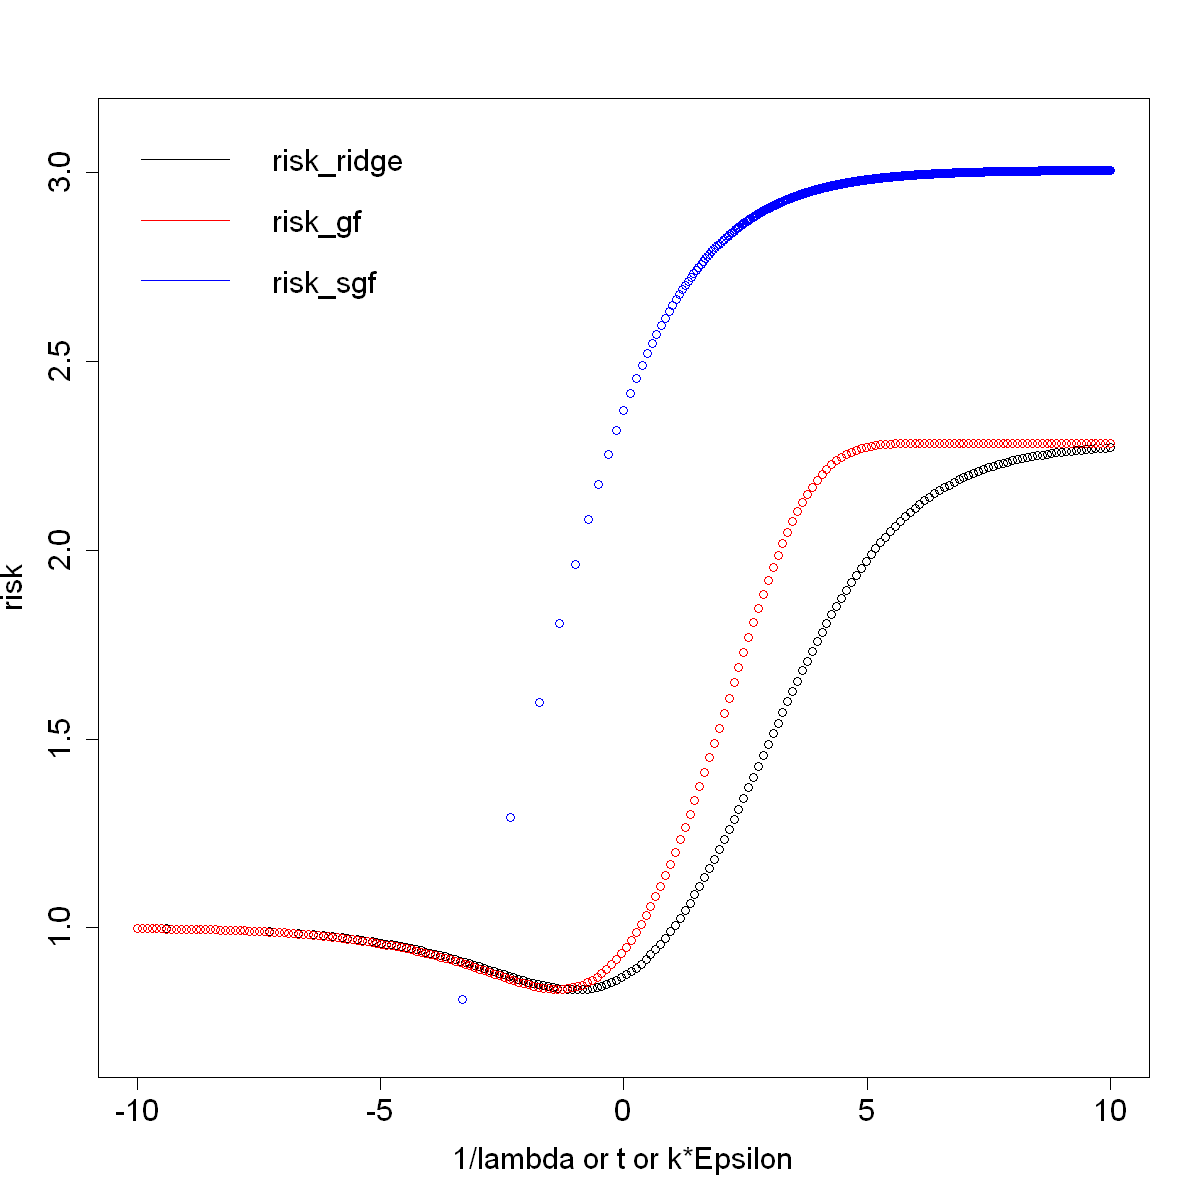

In [77]:
options(repr.plot.width=10, repr.plot.height=10)
plot(1, 1, xlim = c(-10, 10),ylim = c(0.7, 3.1), type = 'n',xlab="1/lambda or t or k*Epsilon",ylab = "risk",cex.axis=1.5,cex.lab=1.5,)   
points(log(1/lam_seq,2), risk_ridge, lty = 1,lwd=1, col = 'black')
points(log(t_seq,2), risk_gf, lty = 1,,lwd=1, col = 'red')  
points(log(seq(1:nk)*Epsilon,2), risk_NC_sde, lty = 1,,lwd=1, col = 'blue') 
legend(x = 'topleft', 
       legend = c('risk_ridge', 'risk_gf', 'risk_sgf'),
       lty = 1,cex=1.5,
       col = c('black', 'red', 'blue'),
       bty = 'n')

## Risk Bounds rho=0.5 n>p

In [91]:
n <- 100
p <- 50
m <- 0.2*n
nrep <- 1
nlam <- 200 # number of lambdas for ridge
nt <- 200 # number of lambdas for GF
nk<- 10240 # number of lambdas for batch-GD and SGD

sigma_noise <- 1
r <- 1
rou <- 0.5

Sigma <- matrix(rou,p,p)
diag(Sigma) <- 1
eigenS <- eigen(Sigma)
D <- eigenS$values
U <- eigenS$vectors
sigma <- U%*%diag(D**0.5)%*%t(U)
W <- matrix(rnorm(n*p,mean=0,sd=sigma_noise),n,p)
X <- W%*%sigma

# D <- eigen(t(X)%*%X)$values
loglam <- seq(log(2^10, 2),-log(2^10, 2),length.out = nlam)
lam_seq <- 2^(loglam)
logt <- seq(-log(2^10, 2),log(2^10, 2),length.out = nt)
t_seq <- 2^(logt)

In [92]:
risk_ridge <- array(0,dim=c(nlam,1))
risk_gf <- array(0,dim=c(nt,1))
risk_NC_sde <- array(0,dim=c(nk,1))

Alpha <- (r^2*n)/(sigma_noise^2*p)

for (i in 1:nlam){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    lambda <- lam_seq[i]
    sum <- 0
    for (j in 1:p){
        sum <- sum + (Alpha*lambda^2+D[j]) / (D[j]+lambda)^2
    } 
    risk_ridge[i] <- sigma_noise^2/n*sum
}

for (i in 1:nt){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    t <- t_seq[i]
    sum <- 0
    for (j in 1:p){
        sum <- sum + Alpha*exp(-2*t*D[j]) + (1-exp(-t*D[j]))^2 / D[j]
    } 
    risk_gf[i] <- sigma_noise^2/n*sum
}

for (i in 1:nk){
    eigenXXn <- eigen(t(X)%*%X/n)
    D <- eigenXXn$values
    U <- eigenXXn$vectors
    # sigma <- U%*%diag(D**0.5)%*%t(U)
    Epsilon = 0.1
    t <- i*Epsilon
    sum <- 0
    for (j in 1:p){
        u = 2*min(D) - n*(n*Epsilon/m)^2*(max(D))^2
        sum <- sum + D[j]/(D[j]-u/2)*(exp(-u*t)-exp(-2*t*D[j]))
    } 
    term_1 <- 0
    term_2 <- 1.6862*sum(diag(sigma_noise^2 * solve(t(X)%*%X+1/t*diag(p))%*%t(X)%*%X%*%solve(t(X)%*%X+1/t*diag(p))))
    # term_3 <- Epsilon*n/m*sum
    term_3 <- 0
    risk_NC_sde[i] <- term_1 + term_2 + term_3
}

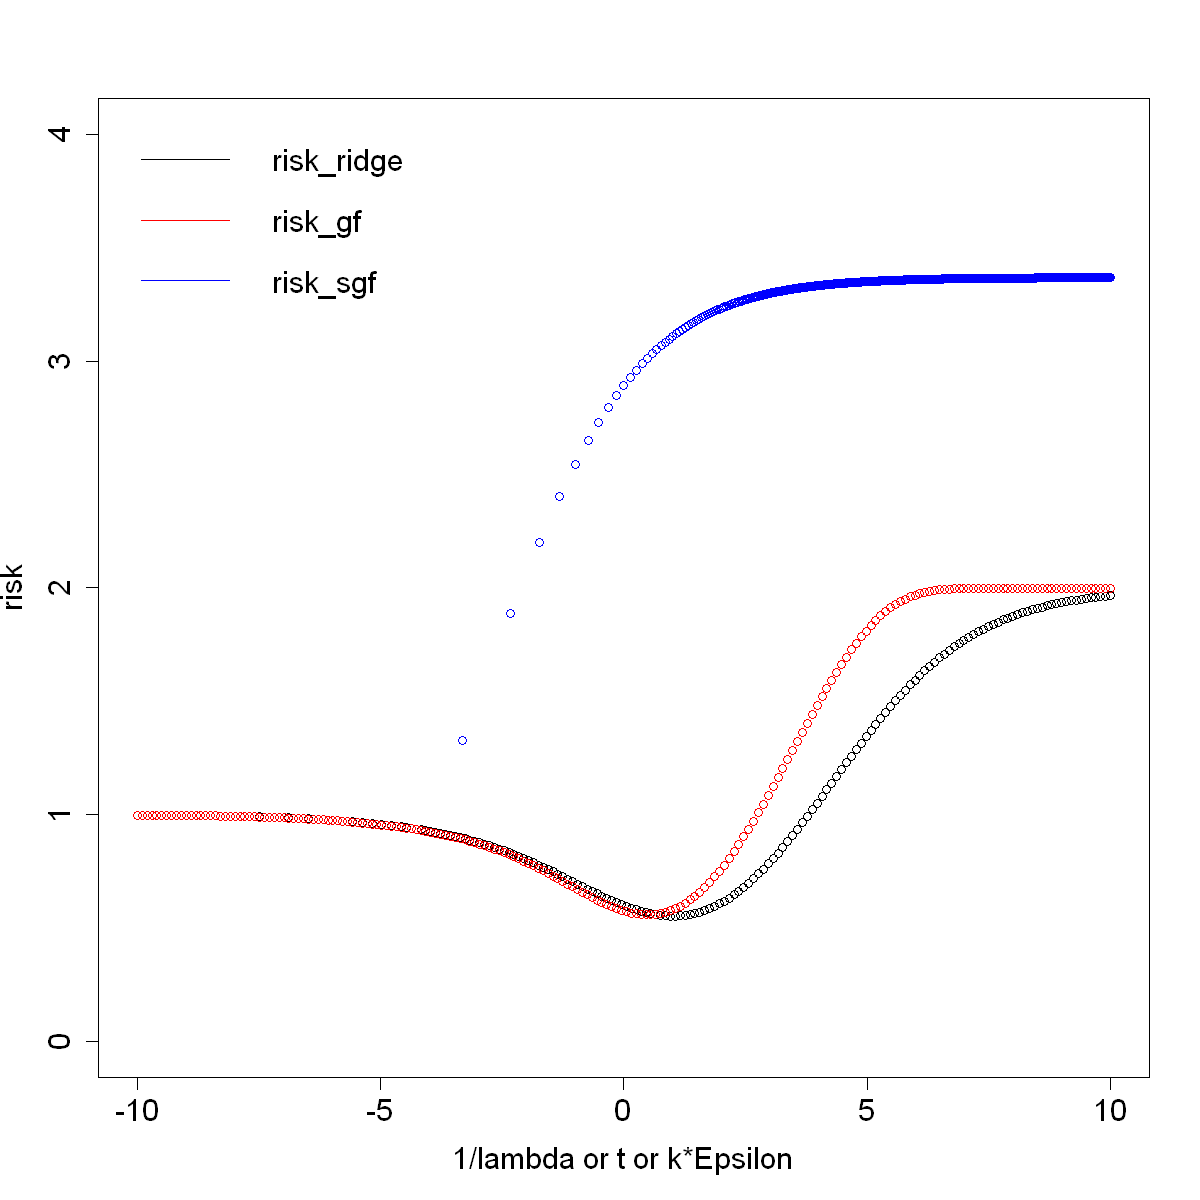

In [97]:
options(repr.plot.width=10, repr.plot.height=10)
plot(1, 1, xlim = c(-10, 10),ylim = c(0, 4), type = 'n',xlab="1/lambda or t or k*Epsilon",ylab = "risk",cex.axis=1.5,cex.lab=1.5,)   
points(log(1/lam_seq,2), risk_ridge, lty = 1,lwd=1, col = 'black')
points(log(t_seq,2), risk_gf, lty = 1,,lwd=1, col = 'red')  
points(log(seq(1:nk)*Epsilon,2), risk_NC_sde, lty = 1,,lwd=1, col = 'blue') 
legend(x = 'topleft', 
       legend = c('risk_ridge', 'risk_gf', 'risk_sgf'),
       lty = 1,cex=1.5,
       col = c('black', 'red', 'blue'),
       bty = 'n')